# Airbnb Rio de Janeiro - XGBoost

# 1. Introdução

Esse notebook propõe aplicar um modelo XGBoost para os [dados do Airbnb na cidade do Rio de Janeiro](https://insideairbnb.com/get-the-data/#:~:text=Rio%20de%20Janeiro%2C%20Rio%20de%20Janeiro%2C%20Brazil). 

Os dados são carregados do processo de [feature engineering](https://github.com/BPRateiro/rio-airbnb-data-analysis/blob/main/notebooks/feature_engineering.ipynb).Incluem informações detalhadas sobre a disponibilidade de listagens, características dos imóveis, interações de usuários, e preços. 

O objetivo principal é construir um modelo com as melhores métricas possíveis.

## 1.1 Configurações e bibliotecas

In [1]:
from xgboost import XGBRegressor
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath('..'))

from rio_airbnb.modeling.train import BayesianXGBoostOptimizer
from rio_airbnb.modeling.predict import load_mais_recente, print_model_metrics
from rio_airbnb.plots import ShapPlotter, plot_feature_importance

2024-10-01 08:44:51.506 | INFO     | rio_airbnb.config:<module>:11 - PROJ_ROOT path is: C:\Bruno\Projects\rio-airbnb-data-analysis


## 1.2 Leitura dos dados

In [2]:
df_train = pd.read_parquet('../data/silver/fe_train_output.parquet')
df_test = pd.read_parquet('../data/silver/fe_test_output.parquet')

df_train.drop(columns=[col for col in df_train.columns if df_train[col].nunique() == 1], inplace=True)
df_train.head()

,accommodates,availability_365,availability_60,bathrooms,bedrooms,beds,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,days_since_first_review,...,review_scores_value,reviews_per_month,verification_email,verification_work_email,was_reviewed,host_response_time_within_a_day,host_response_time_within_a_few_hours,host_response_time_within_an_hour,room_type_others,room_type_private_room
0,5.0,269.0,59.0,2.0,1.0,2.0,1.0,0.0,0.0,131.8,...,4.502,1.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,176.0,56.0,2.0,2.0,0.0,6.0,0.0,0.0,173.0,...,4.500,0.690,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2.0,267.0,59.0,1.0,1.0,1.0,0.0,2.0,0.0,151.4,...,4.600,0.448,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,2.0,38.0,35.0,1.0,1.0,1.0,1.0,1.0,0.0,531.0,...,5.000,0.230,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,5.0,10.0,10.0,2.0,2.0,3.0,1.0,0.0,0.0,3631.0,...,4.740,3.040,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


## 2. Modelo de baseline

In [3]:
# Separando as variáveis independentes e dependentes
X_train = df_train.drop(columns=['price'])
X_test = df_test.drop(columns=['price'])
y_train = df_train['price']
y_test = df_test['price']

modelo_baseline = XGBRegressor()
modelo_baseline.fit(X_train, y_train)
y_pred = modelo_baseline.predict(X_test)

# Avaliar o desempenho com diversas métricas
print_model_metrics(modelo_baseline, X_test, y_test)

[MSE] Mean Squared Error do modelo baseline:  23408.134020892307
[RMSE] Root Mean Squared Error do modelo baseline:  152.99716997674273
[MAE] Mean Absolute Error do modelo baseline:  106.73916695198423
[MAPE] Mean Absolute Percentage Error do modelo baseline:  0.3588437232554324
[R2] R2 Score do modelo baseline:  0.588254088377984


## 3. Modelo otimizado

Utilizaremos o espaço de busca proposto em [Analytics Vidhya - XGBoost Parameters Tuning: A Complete Guide with Python Codes](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/). Mas ao invés de fazer sucessivos passos de `GridSearch`, utilizaremos um único passo com `BayesSearchCV` com o mesmo espaço de busca.

- `n_estimators` (50 a 500): Controla o número de árvores no modelo XGBoost.
- `max_depth` (3 a 10): Define a profundidade máxima de cada árvore, impactando a capacidade do modelo de capturar padrões complexos.
- `min_child_weight` (1 a 6): Especifica o peso mínimo de uma folha, ajudando a controlar o overfitting.
- `gamma` (0 a 0.5): Controla a penalização para divisão de nós, favorecendo divisões mais conservadoras.
- `subsample` (0.6 a 0.9): Define a fração de amostras usadas em cada árvore, reduzindo a correlação entre árvores.
- `colsample_bytree` (0.6 a 0.9): Define a fração de features usadas em cada árvore para reduzir a correlação entre árvores.
- `reg_alpha` (1e-5 a 100, log-uniform): Coeficiente de regularização L1, que incentiva a criação de modelos mais esparsos e ajuda a reduzir o overfitting.

In [5]:
otimizador = BayesianXGBoostOptimizer(n_iter=50, random_state=75)
otimizador.fit(X_train, y_train)

2024-09-24 15:00:37.012 | INFO     | rio_airbnb.modeling.train:fit:151 - Iniciando o processo de ajuste do modelo...
2024-09-24 15:26:04.779 | INFO     | rio_airbnb.modeling.train:fit:154 - Ajuste do modelo concluído.
2024-09-24 15:26:04.837 | INFO     | rio_airbnb.modeling.train:_save_model:128 - Modelo salvo em: C:\Bruno\Projects\rio-airbnb-data-analysis\models\xgb_model_20240924_152604.pkl


In [4]:
modelo_otimizado = load_mais_recente(model_prefix="xgb_model")
print_model_metrics(modelo_otimizado, X_test, y_test)

2024-09-30 13:58:51.226 | INFO     | rio_airbnb.modeling.predict:load_mais_recente:28 - Modelo mais recente carregado: C:\Bruno\Projects\rio-airbnb-data-analysis\models\xgb_model_20240924_152604.pkl
2024-09-30 13:58:51.227 | INFO     | rio_airbnb.modeling.predict:load_mais_recente:32 - O modelo é uma instância de BayesSearchCV, retornando best_estimator_
[MSE] Mean Squared Error do modelo baseline:  21854.287002819798
[RMSE] Root Mean Squared Error do modelo baseline:  147.83195528308417
[MAE] Mean Absolute Error do modelo baseline:  102.28683063133437
[MAPE] Mean Absolute Percentage Error do modelo baseline:  0.3411095060583907
[R2] R2 Score do modelo baseline:  0.615586047277672


## 4. Interpretação dos resultados

### 4.1 Feature Importance

O gráfico abaixo mostra que o número de quartos é a feature mais importante do modelo. Geralmente o número de quartos é um fator determinante no preço de uma propriedade. Se o anfitrião em seguida pode estar relacionado à experiência do usuário e à confiabilidade do locatário. Da mesma forma que o número de quartos, o número de banheiros também é importante ao preço.

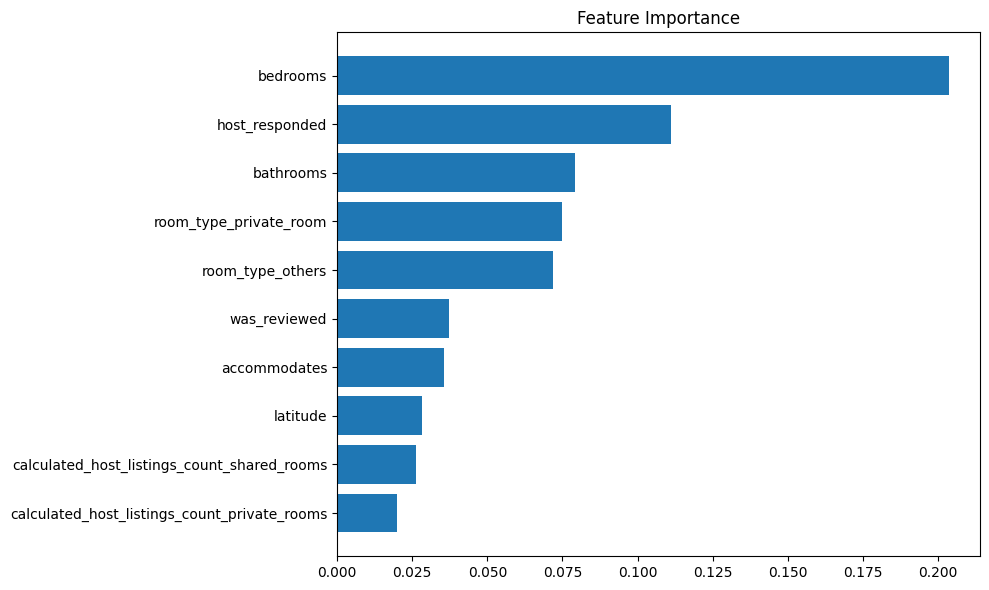

In [5]:
plot_feature_importance(modelo_otimizado, X_train.columns, max_num_features=10)

### 4.2 Dependência parcial

In [6]:
shap_plotter = ShapPlotter(modelo_otimizado, X_train, X_test)

 99%|===================| 6003/6044 [02:16<00:00]        

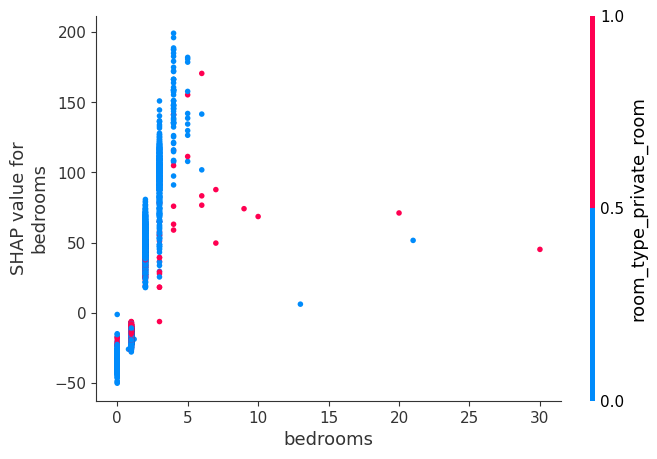

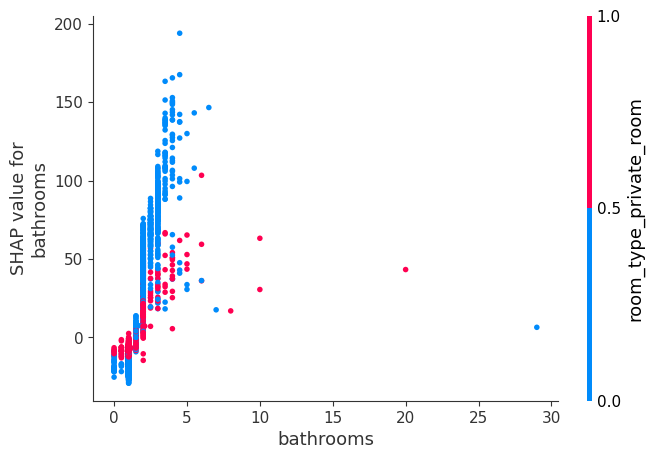

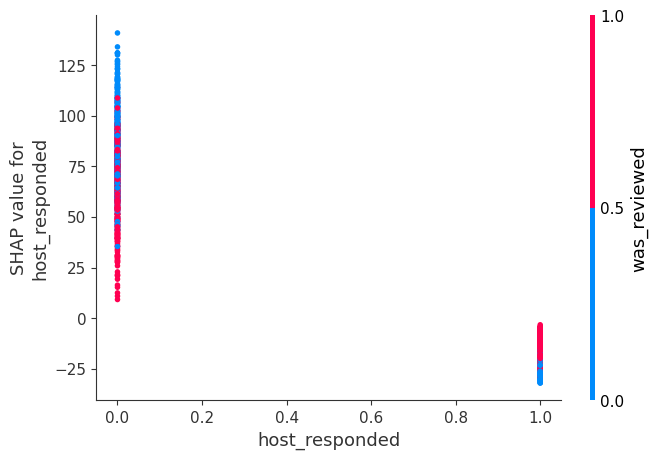

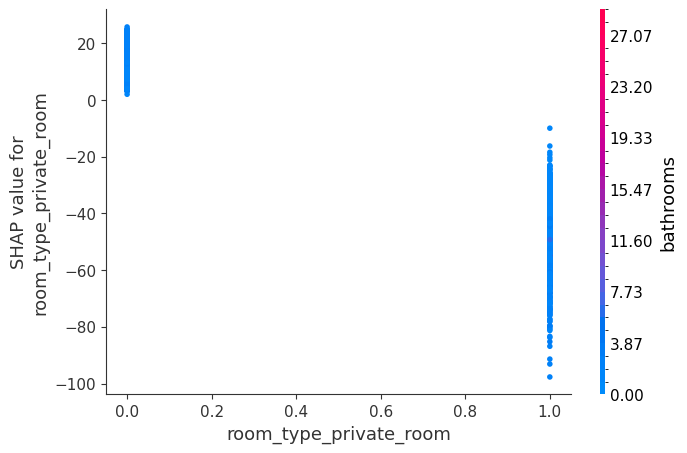

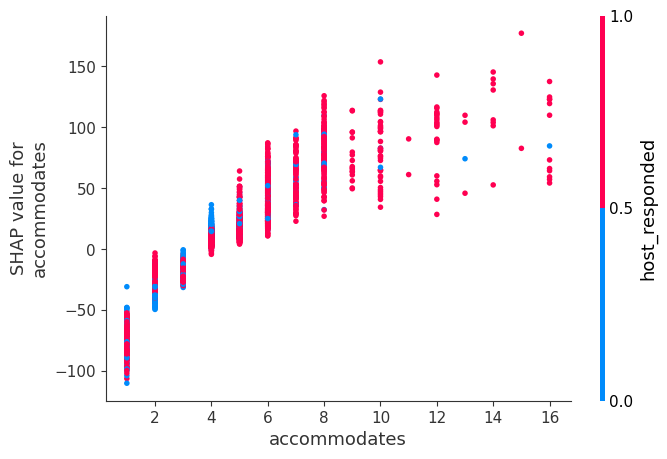

In [11]:
import shap

shap.dependence_plot('bedrooms', shap_plotter.shap_values.values, X_test)
shap.dependence_plot('bathrooms', shap_plotter.shap_values.values, X_test)
shap.dependence_plot('host_responded', shap_plotter.shap_values.values, X_test)
shap.dependence_plot('room_type_private_room', shap_plotter.shap_values.values, X_test)

# shap.dependence_plot('accommodates', shap_plotter.shap_values.values, X_test)

### 4.4 Beeswarm plot

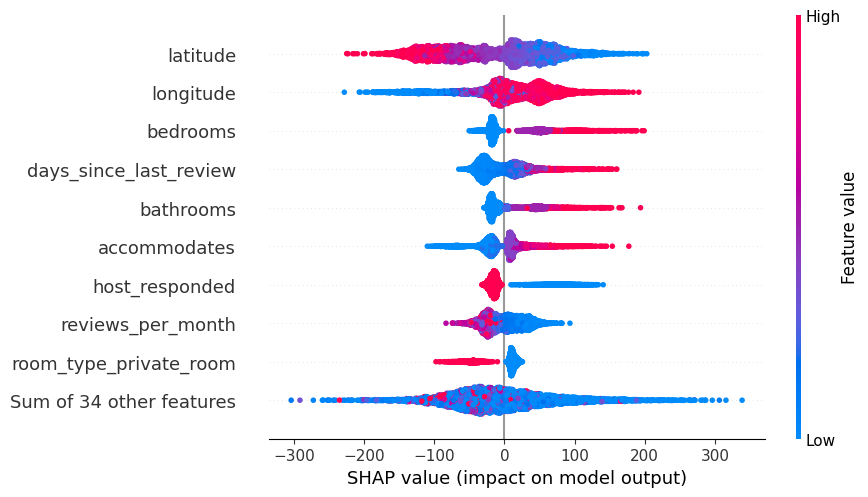

In [16]:
shap.plots.beeswarm(shap_plotter.shap_values)